# Librerias

In [16]:
import mesa
import math
import time
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Clases de Modelo y Agentes

In [17]:
#Funcion auxiliar para obtener el estado 
def get_model_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))

    for cell in model.grid.coord_iter():
        cell_content, x, y = cell

        #Ajustamos los colores de cada celda dependiendo de su contenido
        for content in cell_content:
            #Si es un robot, lo ajustamos dependiendo de el numero de cajas que carga actualmente
            if isinstance(content, RobotAgent):
                grid[x][y] = 11 - content.boxes
            #Si es una casilla, ajustamos el color al numero de cajas en ella
            else:
                grid[x][y] = content.boxes
    return grid

#Agente robot
class RobotAgent(mesa.Agent):
    def __init__(self, unique_id, model, max_stack):
        super().__init__(unique_id, model)
        self.moves = 0
        self.boxes = 0
        self.max_stack = max_stack #Stack maximo posible
        self.move_flag = True #Bandera booleana

    def step(self):
        self.move_flag = True #Reiniciamos la bandera

        #Obtenemos los vecinos del agente
        neighbors = self.model.grid.get_neighbors(
            self.pos,
            moore=False,
            include_center=True
        )

        #Exploramos los diferentes vecinos
        for neighbor in neighbors:
            #Si es una casilla
            if isinstance(neighbor, Tile):
                #Si el robot llega al stack maximo posible y la casilla esta vacia
                if self.boxes == self.max_stack and neighbor.boxes == 0:
                    #El robot deja el stack en la casilla
                    self.boxes = 0
                    neighbor.boxes = self.max_stack
                    self.move_flag = False #Indicamos que el robot no se movera
                    break
                #Si la casilla tiene una caja, y el robot aun tiene capacidad
                elif self.boxes < self.max_stack and neighbor.boxes == 1:
                    neighbor.boxes = 0
                    self.boxes += 1
                    self.move_flag = False
                    break

        #Si el robot se debe mover
        if self.move_flag:
            self.move()

    #Funcion para mover el agente
    def move(self):
        #Obtenemos las casillas disponibles
        neighborhood = self.model.grid.get_neighborhood(
            self.pos,
            moore=False,
            include_center=False
        )
        #Elegimos la siguiente posicion de manera aleatoria
        new_position = self.random.choice(neighborhood)
        self.moves += 1
        self.model.grid.move_agent(self, new_position)

    #Funcion para dejar las cajas en una casilla vacia
    def drop_boxes(self):
        neighbors = self.model.grid.get_neighbors(
            self.pos,
            moore=False,
            include_center=False
        )

        #Dejamos las cajas en la primera casilla vacia disponible
        for neighbor in neighbors:
            if isinstance(neighbor, Tile) and neighbor.boxes == 0:
                neighbor.boxes = self.boxes
                self.boxes = 0
                break

#Agente auxiliar, casilla
class Tile(mesa.Agent):
    def __init__(self, pos, model, boxes=0):
        super().__init__(pos, model)
        self.x, self.y = pos
        self.boxes = boxes #Variable para guardar el numero de cajas en la casilla

#Modelo
class StorageModel(mesa.Model):
    def __init__(self, width, height, K):
        self.num_agents = 5
        self.grid = mesa.space.MultiGrid(width, height, False) #Inicializamos la grid
        self.schedule = mesa.time.SimultaneousActivation(self) #Activamos los agentes de manera simultanea
        self.boxes = K #Numero de cajas en el espacio

        #Posicionamos las cajas en posiciones aleatorias vacias
        empty_cells = list(self.grid.empties)
        for cell in range(self.boxes):
            empty_cell = self.random.choice(empty_cells)
            tile = Tile(empty_cell, self, 1)
            self.grid.place_agent(tile, empty_cell)
            self.schedule.add(tile)
            empty_cells.remove(empty_cell)
            
        #Llenamos el resto de nuestra grid con casillas 'vacias'
        empty_cells = list(self.grid.empties)
        for cell in empty_cells:
            tile = Tile(cell, self)
            self.grid.place_agent(tile, cell)
            self.schedule.add(tile)

        #Posicionamos nuestros agentes en posiciones aleatorias
        for i in range(self.num_agents):
            robot_agent = RobotAgent(i, self, self.max_stack_possible())
            
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)

            self.grid.place_agent(robot_agent, (x, y))
            self.schedule.add(robot_agent)

        #DataCollector
        self.datacollector = mesa.DataCollector(
            model_reporters={'Grid': get_model_grid},
            agent_reporters={'Moves': lambda a: getattr(a, 'moves', None)}
        )

        self.datacollector.collect(self)

    #Funcion step de MESA
    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)

    #Funcion para hacer que todos los agentes coloquen las cajas que llevan en una casilla vacia
    def drop_boxes(self):
        for agent in self.schedule.agents:
            if isinstance(agent, RobotAgent):
                agent.drop_boxes()
        #Agregamos el estado final de la grid en nuestro DataCollector
        self.datacollector.collect(self)

    #Funcion para obtener el stack mas grande posible por robot de acuerdo al numero de cajas disponibles
    #Regresamos 5, si el maximo excede este valor
    def max_stack_possible(self):
        max_stack = math.ceil(self.boxes / 5)
        return 5 if max_stack > 5 else max_stack

    #Funcion para indicar si aun quedan cajas sin acomodarse
    def boxes_available(self):
        for cell in self.grid.coord_iter():
            cell_content, x, y = cell

            for content in cell_content:
                if isinstance(content, Tile) and content.boxes == 1:
                    return True

        return False

# Ejecución del modelo

## Parámetros de ejecución

In [18]:
max_exec_time = 1 #Tiempo maximo de ejecucion
model = StorageModel(15, 15, 25) #Inicializacion de modelo

## Ejecución de modelo y medición de tiempo de ejecución

In [19]:
#Medimos tiempo de ejecucion
init_time = time.time()
#Avanzamos en el modelo mientras queden cajas sin acomodarse o no se haya pasado el tiempo maximo
while model.boxes_available() or time.time() - init_time > max_exec_time:
    model.step()
end_time = time.time()
model.drop_boxes() #Al finalzar, forzamos a los robots a dejar las cajas recogidas

exec_time = end_time - init_time #Tiempo de ejecucion del modelo

# Visualización del modelo

## Información del modelo

In [20]:
#Obtenemos las iteraciones de la grid del modelo
data = model.datacollector.get_model_vars_dataframe()
data.head()

,Grid
0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0..."
1,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0..."
2,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0..."


# Información de los agentes

In [27]:
#Obtenemos los movimientos de los agentes
agents_data = []
for agent in model.schedule.agents:
    if isinstance(agent, RobotAgent):
        agents_data.append(agent.moves)

[110, 116, 111, 117, 113]

## Gráfica del número de movimientos por cada agente

<BarContainer object of 5 artists>

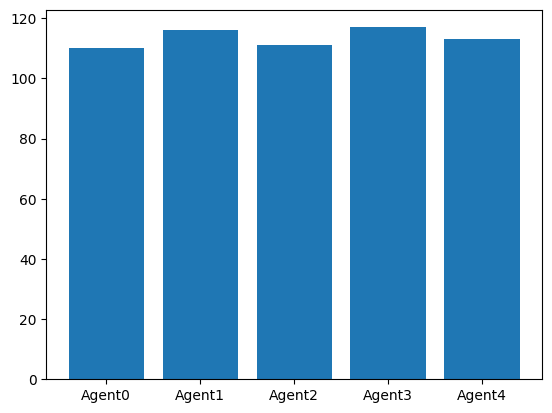

In [30]:
agent_names = ['Agent0', 'Agent1', 'Agent2', 'Agent3', 'Agent4']
plt.bar(agent_names, agents_data)

## Animación

In [22]:
%%capture

#Generamos la grafica del frame incial
figure, axis = plt.subplots(figsize=(7,7))
axis.set_xticks([])
axis.set_yticks([])
#patch = plt.imshow(data.iloc[0][0], cmap='Greys')
patch = plt.imshow(data.iloc[0][0], interpolation="nearest")
plt.colorbar()

#Funcion inicial para generar la animacion
def animate(i):
    patch.set_data(data.iloc[i][0])

anim = animation.FuncAnimation(figure, animate, frames=len(data))

In [23]:
anim